# **Dynamics of Quantum Emitters coupled at the edges of an extended SSH lattice**

In this notebook, we present the code we used for simulating the dynamics of a single quantum emitter (QE) coupled at the edge of an extended SSH lattice.  

In [12]:
import numpy as np
from scipy import integrate
from scipy import linalg as LA
from scipy.misc import derivative
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# Dictionary of hopping amplitudes in different topological phases, all
# reproducing the same band-gap width of E_g /J = 2.21

winding_to_hoppings = {'-1': (1,1,2,0.5), '1':(1,1,0.5,-0.76),
                    '2': (1,1,0.5,2), '0': (1,1,-0.76,0.5)}
                    

We will start by defining the hamiltonian. We consider a single QE coupled simultaneously to both sites of the unit cell $j=0$ (the leftmost unit cell of the lattice). The interaction hamiltonian is of the form
\begin{equation}
\mathcal{H} = \mathcal{H}_\text{ eSSH} + g\left(a_0^\dagger+b_0^\dagger\right)\sigma_{eg}+ \text{H.c.}\;,
\end{equation}
where $\sigma_{eg}=|e\rangle\langle g|$, being $|g\rangle$ and $|e\rangle$ the ground and excited states of the QE. Let's start by building this hamiltonian.

In [13]:
def Hamiltonian_edge_QE(hoppings, g, Delta, N_cells):
    """
    Returns the hamiltonian describing the interaction of one or two QEs
    (depending on the argument N_e), at detuning Delta, coupled to an extended
    SSH bath with input hoppings with coupling constant g.
    
    """
    # Retrieve hoppings from list
    t1, t2, r1, r2 = hoppings
    
    # We start by builing the bath hamiltonian
    
    M = 2*N_cells
    H_b = np.zeros( (M, M) )
    
    for i in range(M-3):
        
        if i%2 == 0:
        
            H_b[i, i+1] = t1 
            H_b[i, i+3] = r1 
        
            # Impose hermiticity
            H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
            H_b[i+2,i] = H_b[i, i+2]
            
        else:
            
            H_b[i, i+1] = t2
            H_b[i, i+3] = r2
        
            # Impose hermiticity
            H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
            H_b[i+2,i] = H_b[i, i+2]
            
    # Regarding the right edge:
    
    H_b[M-3, M-2] = t2  
    H_b[M-2, M-1] = t1
    H_b[M-2, M-3], H_b[M-1, M-2] = H_b[M-3, M-2], H_b[M-2, M-1]

    # Coupling the giant atom
    
    H = np.zeros((M+1,M+1))
    em = np.zeros((M+1))
    em[0] = Delta
    em[1] = g
    em[2] = g
    H[0, :], H[:, 0] = em, em
    H[1:, 1:] = H_b
    
    return H

In our case, it is computationally accessible to simulate the dynamics by numerical exponentiation of the hamiltonian applied to the initial state at time $t_0=0$, which in the case of a single QE is $|e\rangle|\text{vac}\rangle$:
\begin{equation}
|\Psi(t)\rangle = \mathcal{U}(t,t_0)|e\rangle|\text{vac}\rangle
\end{equation}
while in the case of two QEs we will only consider that only one of them is initially excited $|\Psi(t_0)\rangle=|e\rangle|g\rangle|\text{vac}\rangle$:
\begin{equation}
|\Psi(t)\rangle = \mathcal{U}(t,t_0)|e\rangle|g\rangle|\text{vac}\rangle\;,
\end{equation}
with $\mathcal{U}(t,t_0)=\exp\left(-i\mathcal{H}(t-t_0)\right)$.

In [18]:
def evolution_operator(H, delta_t):
    """
    Computes the evolution operator generated by a hamiltonian H over a 
    timelapse delta_t 
    """

    U = LA.expm(-(1j*delta_t)*H)
    
    return U

def QE_dynamics(hoppings, g, Delta, N_cells, T, n):
    """
    Computes the evolution of C_e(t), the coefficient associated to a QE
    when coupled to a photonic bath in n jumps during a time interval of
    duration T
    """
    
    # Declare initial state and unit of time dt
    psi = np.zeros((2*N_cells+1))
    psi[0] =  1
    
    dt = T/n
    
    # Declare hamiltonian of the problem and finite difference evolution 
    # operator
    
    H = Hamiltonian_edge_QE(hoppings, g, Delta, N_cells)
    U = evolution_operator(H, dt)
    
    # Initialize emitter(s) population list
    Ce = np.array([], dtype = complex)
    Ce2 = np.array([], dtype = complex)
    
    for i in range(n):

        # Actualize state
        psi = np.dot(U, psi)
        
        # Append value of coefficient
        Ce = np.append(Ce, psi[0]*psi[0].conj())
        
    return np.real(Ce)

In the manuscript of this work, we motivated the need of exploring QE evolution in small lattices in order to identify dynamical features that are sensitive to the multiplicity of edge states, which is equal to $2|\mathcal{W}|$. In order to do so, we compare the evolution of the population of a QE in time and frequency domains in a large ($N=120$ sites) and small ($N=20$ sites) lattices, and observe that the dynamics in the topological phase with $\mathcal{W}>1$ has a richer frequency domain spectrum in the small lattice size regime.

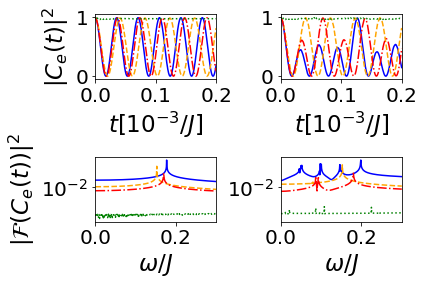

In [19]:
# Time evolution and its Fourier transform in large and small lattices   

g, N_large, N_small, T, n = 0.1, 120, 10, 1e4, int(1e5)
Delta = 0

# Compute dynamics
C_r_large = QE_dynamics(winding_to_hoppings['2'], g, Delta, N_large, T, n)
C_l_large = QE_dynamics(winding_to_hoppings['1'], g, Delta, N_large, T, n)
C_u_large = QE_dynamics(winding_to_hoppings['-1'], g, Delta, N_large, T, n)
C_d_large = QE_dynamics(winding_to_hoppings['0'], g, Delta, N_large, T, n)

C_r_small = QE_dynamics(winding_to_hoppings['2'], g, Delta, N_small, T, n)
C_l_small = QE_dynamics(winding_to_hoppings['1'], g, Delta, N_small, T, n)
C_u_small = QE_dynamics(winding_to_hoppings['-1'], g, Delta, N_small, T, n)
C_d_small = QE_dynamics(winding_to_hoppings['0'], g, Delta, N_small, T, n)

# Compute Fourier transforms
F_r_large = np.fft.fft(C_r_large)/n
F_l_large = np.fft.fft(C_l_large)/n
F_u_large = np.fft.fft(C_u_large)/n
F_d_large = np.fft.fft(C_d_large)/n

F_r_small = np.fft.fft(C_r_small)/n
F_l_small = np.fft.fft(C_l_small)/n
F_u_small = np.fft.fft(C_u_small)/n
F_d_small = np.fft.fft(C_d_small)/n

F_r_large = abs(F_r_large[range(int(n/2))])
F_l_large = abs(F_l_large[range(int(n/2))])
F_u_large = abs(F_u_large[range(int(n/2))])
F_d_large = abs(F_d_large[range(int(n/2))])

F_r_small = abs(F_r_small[range(int(n/2))])
F_l_small = abs(F_l_small[range(int(n/2))])
F_u_small = abs(F_u_small[range(int(n/2))])
F_d_small = abs(F_d_small[range(int(n/2))])

# Declare frequencies
dt = T/n
sampling_frequency = 1/dt 
time_period = n/sampling_frequency
frecs = 2*np.pi*np.arange(int(n/2))/time_period
time = np.linspace(0, T, n)/1000

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False)
axes[0,0].plot(time, C_r_large, color='blue', linestyle='solid')
axes[0,0].plot(time, C_l_large, color='orange', linestyle='dashed')
axes[0,0].plot(time, C_u_large, color='red', linestyle='dashdot')
axes[0,0].plot(time, C_d_large, color='green', linestyle='dotted')
axes[0,0].set_xlim([0, 0.2])
axes[0,0].set_ylabel('$|C_e(t)|^2$', fontsize=23)
axes[0,0].set_xlabel('$t[10^{-3}/J]$', fontsize=23)

axes[0,1].plot(time, C_r_small, color='blue', label='$\mathcal{W}=2$', linestyle='solid')
axes[0,1].plot(time, C_l_small, color='orange', label='$\mathcal{W}=1$', linestyle='dashed')
axes[0,1].plot(time, C_u_small, color='red', label='$\mathcal{W}=-1$', linestyle='dashdot')
axes[0,1].plot(time, C_d_small, color='green', label='$\mathcal{W}=0$', linestyle='dotted')
axes[0,1].set_xlim([0, 0.2])
axes[0,1].set_xlabel('$t[10^{-3}/J]$', fontsize=23)


axes[1,0].plot(frecs[1:], 1e3*F_r_large[1:], color='blue', label='$\mathcal{W}=2$',
        linestyle='solid')
axes[1,0].plot(frecs[1:], 1e2*F_l_large[1:], color='orange', label='$\mathcal{W}=1$',
        linestyle='dashed')
axes[1,0].plot(frecs[1:], 10*F_u_large[1:], color='red', label='$\mathcal{W}=-1$',
        linestyle='dashdot')
axes[1,0].plot(frecs[1:], F_d_large[1:], color='green', label='$\mathcal{W}=0$',
        linestyle='dotted')
axes[1,0].set_xlim([0, 0.3])
axes[1,0].set_ylabel('$|\mathcal{F}(C_e(t))|^2$', fontsize=23)
axes[1,0].set_xlabel('$\omega/J$', fontsize=23)
axes[1,0].set_yscale('log')

axes[1,1].plot(frecs[1:], 1e3*F_r_small[1:], color='blue', label='$\mathcal{W}=2$',
        linestyle='solid')
axes[1,1].plot(frecs[1:], 1e2*F_l_small[1:], color='orange', label='$\mathcal{W}=1$',
        linestyle='dashed')
axes[1,1].plot(frecs[1:], 10*F_u_small[1:], color='red', label='$\mathcal{W}=-1$',
        linestyle='dashdot')
axes[1,1].plot(frecs[1:], F_d_small[1:], color='green', label='$\mathcal{W}=0$',
        linestyle='dotted')
axes[1,1].set_xlim([0, 0.3])
axes[1,1].set_xlabel('$\omega/J$', fontsize=23)
axes[1,1].set_yscale('log')
plt.tight_layout()